In [ ]:
# Install requirements, uncomment to run
# !pip install geopandas pillow label-studio-converter

# Uploading Savmap dataset to label studio

In [ ]:
import geopandas as gdp
from PIL import Image
from tqdm import tqdm
import os
from pathlib import Path
import numpy as np
import json
import pandas as pd
from torchvision.ops import nms
import torch
from label_studio_sdk import Client
from dotenv import load_dotenv
from label_studio_tools.core.utils.io import get_local_path
from urllib.parse import unquote
import traceback

In [ ]:
#  load data
root = r"D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data"
polygons = gdp.read_file(os.path.join(root,'savmap_annotations_2014.geojson'))

path_to_images = os.path.join(root,'images')
path_to_labels = os.path.join(root,'labels')

In [ ]:
# # polygon points
# xx,yy = polygons['geometry'].iloc[0].exterior.coords.xy
# np.array(list(zip(xx,yy))) * 100 / np.array([4000,3000]).reshape((1,2))

In [ ]:
# get bounding boxs
for cat in ['x_min', 'y_min', 'x_max', 'y_max','width','height','x','y']:
    polygons[cat] = None
for i in tqdm(range(len(polygons))):
    x_min, y_min, x_max, y_max = polygons['geometry'].iloc[i].bounds
    image_path = os.path.join(path_to_images,f"{polygons['IMAGEUUID'].iloc[i]}.JPG")
    # try:
    width, height = Image.open(image_path).size
    # except:
    #     continue
    polygons['x_min'].iat[i] = max(int(x_min),0)
    polygons['x_max'].iat[i] = max(int(x_max),0)
    polygons['y_min'].iat[i] = max(int(y_min),0)
    polygons['y_max'].iat[i] = max(int(y_max),0)
    polygons['x'].iat[i] = 0.5*(x_max+x_min)
    polygons['y'].iat[i] = 0.5*(y_max+y_min)
    polygons['width'].iat[i] = width
    polygons['height'].iat[i] = height

polygons['bbox_w'] = (polygons['x_max'] - polygons['x_min'])*1.0
polygons['bbox_h'] = (polygons['y_max'] - polygons['y_min'])*1.0
polygons['class'] = 0

In [ ]:
# non-max suppresion
# https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html

def nms_to_bbox(df_annotations:pd.DataFrame,iou_threshold:float=0.5):
    dfs = list()

    for IMAGEUUID, df in tqdm(df_annotations.groupby('IMAGEUUID')):

        df.reset_index(inplace=True)

        bbox = df[['x_min','y_min','x_max','y_max']].to_numpy().astype(float)
        scores = np.ones((bbox.shape[0],)).astype(float)

        bbox_indices= nms(boxes=torch.from_numpy(bbox),
                            scores=torch.from_numpy(scores),
                            iou_threshold=iou_threshold).numpy()
        
        # print(bbox[bbox_indices],'\n',df.iloc[bbox_indices,:])

        dfs.append(df.iloc[bbox_indices,:].copy())

    return pd.concat(dfs,axis=0).reset_index()

In [ ]:
# nms filtering of bbox
df_filtered = nms_to_bbox(polygons,iou_threshold=0.4)
df_filtered.rename(columns={'class':'labels'},inplace=True)

In [ ]:
df_filtered.drop(columns=['level_0','index'],inplace=True)

In [ ]:
# filtered df vs unfiltered df
len(df_filtered), len(polygons)

In [ ]:
df_filtered.head(1)

In [ ]:
# save filtered annotations as csv
savepath = os.path.join(root,'savmap_annotations_2014_filtered.csv')
df_filtered['images'] = df_filtered['IMAGEUUID'].apply(lambda x: f"{x}.JPG")
df_filtered.to_csv(savepath,index=False)

In [ ]:
savepath = os.path.join(root,'savmap_annotations_2014_filtered.csv')
df_filtered = pd.read_csv(savepath)
df_filtered.head(2)

In [ ]:
# Tiling images
!python ../../HerdNet/tools/patcher.py "D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\images" 2000 2000 100 -dest "D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\images_splits" -csv "D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\savmap_annotations_2014_filtered.csv" -min 0.5 -all False

In [ ]:
# load groundtruth for split images
path_to_images_splits = r"D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\images_splits"
df_splits = pd.read_csv(os.path.join(path_to_images_splits,"..\gt_splits.csv"))

try:
    df_splits["IMAGEUUID"] = df_splits['images'].apply(lambda x: str(x).split(".")[0])
    df_splits['x'] = df_splits["x_min"] #+df_splits["x_max"])
    df_splits['y'] = df_splits["y_min"] #+df_splits["y_max"])
    df_splits["width"] = 0.
    df_splits["height"] = 0.
    df_splits['bbox_w'] = df_splits['x_max'] - df_splits['x_min']
    df_splits['bbox_h'] = df_splits['y_max'] - df_splits['y_min']
    
except Exception as e:
    traceback.print_exc()
    df_splits['x'] = df_splits['x'] - 0.5*df_splits['bbox_w']
    df_splits['y'] = df_splits['y'] - 0.5*df_splits['bbox_h']


for name,df in tqdm(df_splits.groupby("images")):
    image_path = os.path.join(path_to_images_splits,name)
    width, height = Image.open(image_path).size
    mask = (df_splits["images"] == name)
    df_splits.loc[mask,'width']  = width
    df_splits.loc[mask,'height'] = height

In [ ]:
df_splits.head(3)

In [ ]:
# Select labels
# data = polygons.loc[:,['x_min','x_max','y_min','y_max','IMAGEUUID','width','height','class']].copy()
# data.rename(columns={'IMAGEUUID':'filename',
#                      'x_max':'xmax',
#                      'x_min':'xmin',
#                      'y_min':'ymin',
#                      'y_max':'ymax'},inplace=True)
# data['filename'] = data['filename'].apply(lambda x: f"{x}.JPG")
# data = data.dropna()
# data = data[['filename','class','width', 'height','xmin','ymin','xmax','ymax']]
# data.head(1)


In [ ]:
# # Convert CSV to COCO
# save_json_path = ... #'cocoformat.json'

# images = []
# categories = []
# annotations = []

# category = {}
# category["supercategory"] = 'None'
# category["id"] = 0
# category["category_name"] = 'wildlife'
# categories.append(category)

# data['fileid'] = data['filename'].astype('category').cat.codes
# data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
# # data['categoryid'] = data['categoryid']+1
# data['annid'] = data.index

# def image(row):
#     image = {}
#     image["height"] = row.height
#     image["width"] = row.width
#     image["id"] = row.fileid
#     image["file_name"] = row.filename
#     return image

# # def category(row):
# #     category = {}
# #     category["supercategory"] = 'None'
# #     category["id"] = row.categoryid
# #     category["category_name"] = row[2]
# #     return category

# def annotation(row):
#     annotation = {}
#     area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
#     annotation["segmentation"] = []
#     annotation["iscrowd"] = 0
#     annotation["area"] = area
#     annotation["image_id"] = row.fileid
#     annotation["score"] = 1.0

#     annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]

#     annotation["category_id"] = row.categoryid
#     annotation["id"] = row.annid
#     return annotation

# for row in data.itertuples():
#     annotations.append(annotation(row))

# imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
# for row in imagedf.itertuples():
#     images.append(image(row))

# # catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
# # for row in catdf.itertuples():
# #     categories.append(category(row))

# data_coco = {}
# data_coco["images"] = images
# data_coco["categories"] = categories
# data_coco["annotations"] = annotations
# # json.dump(data_coco, open(save_json_path, "w"), indent=4)

In [ ]:
# groundtruth = {annot['file_name']:[] for annot in data_coco['images']}
# for annot,image_data in zip(data_coco['annotations'],data_coco['images']):
#     annot.update(image_data)
#     # pprint.pp(annot)
#     annot['category_name'] = category['category_name']
#     groundtruth[annot['file_name']].append(annot)

In [ ]:
dotenv_path = r"..\.env"
if dotenv_path is not None:
    load_dotenv(dotenv_path=dotenv_path)

In [ ]:
# Connect to the Label Studio API and check the connection
LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL')
API_KEY = os.getenv("LABEL_STUDIO_API_KEY")
labelstudio_client = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

In [ ]:
# url = "/data/local-files/?d=Users%5Cfadel%5COneDrive%5CBureau%5CWILD-AI%5Cdatalabeling%5Cdata%5Ctrain_wildai%5Cimages%5C003a34ee6b7841e6851b8fe511ebe102.JPG"

In [ ]:
# unquote(url)

In [ ]:
# Uploading Polygons
def format_prediction_polygon(points:list,width:int,height:int,label:list=['wildlife',]):
    
    template = {
            "original_width": width,
            "original_height": height,
            "image_rotation": 0,
            "value": {
                "points": points,
                "closed":True,
                "polygonlabels": label
            }
    }

    return template

def format_predictions_polygon(polygons:list,widths:list,heights:list,label:list=['wildlife',]):

    results = list()
    for polygon,w,h in zip(polygons,widths,heights):
        xx,yy=polygon.exterior.coords.xy
        points = list(zip(xx,yy))

        # convert points to percent
        points = np.array(points) * 100 / np.array([w,h]).reshape((1,2))
        points = points.tolist()      

        # append result
        results.append(format_prediction_polygon(points,width=w,height=h,label=label))

    return results


# uploading polygons
 # Select project
# project = labelstudio_client.get_project(id=project_id)
# # Upload predictions for each task
# tasks = project.get_tasks()
# if top_n > 0:
#     tasks = sorted(tasks,key=lambda x:x['id'])[:top_n]

for task in tqdm(tasks[:10],desc="Uploading predictions"):
    task_id = task['id']
    img_url = unquote(task['data']['image'])
    img_path = get_local_path(img_url)
    img_name = Path(img_path).stem
    mask = polygons['IMAGEUUID']==img_name
    polys = polygons.loc[mask,['IMAGEUUID','geometry','width','height']]
    formatted_pred = format_predictions_polygon(polygons=polys['geometry'],widths=polys['width'],heights=polys['height'],label=['wildlife',])
    # conf_scores = [pred['score'] for pred in prediction]
    # max_score = 0.0
    project.create_prediction(task_id=task_id,
                               result=formatted_pred,model_version='gt')

In [ ]:
import traceback

# uploading gt bbox
def format_prediction_bbox(pred:dict,img_height:int,img_width:int,
                           from_name:str='label',
                           to_name:str='image',
                           label_type:str='rectanglelabels') -> dict:
        """Converts prediction Label studio format

        Args:
            pred (dict): prediction in coco format
            img_height (int): image height
            img_width (int): image width

        Returns:
            dict: Label studio formated prediction
        """
        # formatting the prediction to work with Label studio
        x, y, width, height = pred['bbox']
        label = pred['category_name']
        # score = pred['score']
        # if not isinstance(score,float):
        #     score = 0.0
        template = {
                    "from_name": from_name,
                    "to_name": to_name,
                    "type": label_type,
                    "original_width":img_width,
                    "original_height":img_height,
                    "image_rotation":0,
                    'value': {
                        label_type: [label,],
                        'x': x / img_width * 100.,
                        'y': y / img_height * 100.,
                        'width': width / img_width * 100.,
                        'height': height / img_height * 100.,
                        'rotation':0.
                    },
                    # 'score': score
        }
        return template

def format_predictions_bbox(xs:list,ys:list,ws:list,hs:list,img_width:int,img_height:int,label:str='wildlife'):
      
    results = list()
    for x,y,w,h in zip(xs,ys,ws,hs):
        
        annot = {'bbox':[x,y,w,h],
                 'category_name':label,
                 'score':None
                 }

        # append result
        results.append(format_prediction_bbox(annot,img_width=img_width,img_height=img_height))

    return results

def upload_predictions_bbox(df_annotations:pd.DataFrame,project_id:int):

    # get tasks
    project = labelstudio_client.get_project(id=project_id)
    tasks = project.get_tasks()

    # upload
    failed_uploads = set()
    for task in tqdm(tasks[:],desc="Uploading predictions"):
        task_id = task['id']
        img_url = unquote(task['data']['image'])
        img_path = get_local_path(img_url)
        img_name = Path(img_path).stem
        try:
            mask = df_annotations['IMAGEUUID']==img_name
            df_bbox = df_annotations.loc[mask,['x','y','bbox_w','bbox_h','width','height']]
            img_width = df_bbox['width'].iat[0]
            img_height = df_bbox['height'].iat[0]
            formatted_pred = format_predictions_bbox(xs=df_bbox['x'],
                                                    ys=df_bbox['y'],
                                                    ws=df_bbox['bbox_w'],
                                                    hs=df_bbox['bbox_h'],
                                                    img_width=int(img_width),
                                                    img_height=int(img_height),
                                                    label='wildlife'
                                                    )
            # project.create_annotation(task_id=task_id,
            #                         result=formatted_pred,
            #                         # model_version='gt'
            #                         )
            project.create_prediction(task_id=task_id,
                                    result=formatted_pred,
                                    model_version='gt')
        except Exception as e:
            # skipping empty df
            if len(df_bbox)<1:
                failed_uploads.add(task_id)
                continue
            else:
                print("Failed for: ",img_name,df_bbox,end="\n")
                traceback.print_exc()
                break
    return failed_uploads

def delete_tasks(project_id:int,failed_uploads:set[int]):

    # get project
    project = labelstudio_client.get_project(id=project_id)

    # delete tasks
    for task_id in tqdm(failed_uploads,desc="deleting tasks"):
        project.delete_task(task_id=task_id)

In [ ]:
# savmap original
project_id = 71
failed_uploads = upload_predictions_bbox(df_annotations=df_filtered,project_id=project_id)

In [ ]:
len(failed_uploads)

In [ ]:
# savmap splits
project_id = 70
failed_uploads = upload_predictions_bbox(df_annotations=df_splits,project_id=project_id)

In [ ]:
len(failed_uploads)

In [ ]:
# delete empty images
delete_tasks(project_id=project_id,failed_uploads=failed_uploads)

In [ ]:
# format_predictions(polygons=polys['geometry'],widths=polys['width'],heights=polys['height'],label=['wildlife',])

# Formatting savmap dataset
Formatting the savmap dataset so it can be imported in label studio through a json file

In [ ]:
import geopandas as gdp
from PIL import Image
from tqdm import tqdm
import os
from pathlib import Path

In [ ]:
#  load data
root = r"D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data"
polygons = gdp.read_file(os.path.join(root,'savmap_annotations_2014.geojson'))

# create directories
path_to_images = os.path.join(root,'images')
path_to_labels = os.path.join(root,'labels')
Path(path_to_images).mkdir(exist_ok=True,parents=True)
Path(path_to_labels).mkdir(exist_ok=True,parents=True)

In [ ]:
# Move files
# ! mv ../data/savmap_dataset_v2/*.JPG ../data/savmap_dataset_v2/images

In [ ]:
# get bounding boxs
for cat in ['x_min', 'y_min', 'x_max', 'y_max','width','height','x','y']:
    polygons[cat] = None
for i in range(len(polygons)):
    x_min, y_min, x_max, y_max = polygons['geometry'].iloc[i].bounds
    image_path = os.path.join(path_to_images,f"{polygons['IMAGEUUID'].iloc[i]}.JPG")
    width, height = Image.open(image_path).size
    polygons['x_min'].iat[i] = max(0,int(x_min))
    polygons['x_max'].iat[i] = max(0,int(x_max))
    polygons['y_min'].iat[i] = max(0,int(y_min))
    polygons['y_max'].iat[i] = max(0,int(y_max))
    polygons['x'].iat[i] = 0.5*(x_max+x_min)
    polygons['y'].iat[i] = 0.5*(y_max+y_min)
    polygons['width'].iat[i] = width
    polygons['height'].iat[i] = height

# creat bbox width and height
polygons['bbox_w'] = polygons['x_max'] - polygons['x_min']
polygons['bbox_h'] = polygons['y_max'] - polygons['y_min']
polygons['class'] = 0

In [ ]:
polygons.head(1)

In [ ]:
# convert to yolo format
def save_df_as_yolo(df_annotation:gdp.GeoDataFrame,dest_path_labels:str):
    
    cols = ['class','x','y','bbox_w','bbox_h']
    for col in cols:
        assert df_annotation[col].isna().sum()<1,'there are NaN values. Check out.'
        # df_annotation[col] = df_annotation[col].apply(int)

    # normalize values
    df_annotation.loc[:,'x'] = df_annotation['x']/df_annotation['width']
    df_annotation.loc[:,'y'] = df_annotation['y']/df_annotation['height']
    df_annotation.loc[:,'bbox_w'] = df_annotation['bbox_w']/df_annotation['width']
    df_annotation.loc[:,'bbox_h'] = df_annotation['bbox_h']/df_annotation['height']
    
    for image_name,df in tqdm(df_annotation.groupby('IMAGEUUID'),desc='Saving yolo labels'):
        txt_file = f'{image_name}.txt'
        df[cols].to_csv(os.path.join(dest_path_labels,txt_file),sep=' ',index=False,header=False)

In [ ]:
save_df_as_yolo(df_annotation=polygons,dest_path_labels=path_to_labels)

In [ ]:
# tutorial here: https://github.com/HumanSignal/label-studio-converter/tree/master
# if it does not work, use a terminal
# !label-studio-converter import yolo -i "C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\data\train_wildai" --image-ext ".JPG" --out-type "predictions" -o "C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\data\train_wildai\ls_tasks.json"

# Formatting General Dataset from Delplanque 2021

In [ ]:
import pandas as pd
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm


### Tiling

In [ ]:
# Tiling test
# !python ../../HerdNet/tools/patcher.py "D:\PhD\Data per camp\Extra training data\general_dataset\test" 640 640 64  -dest "D:\PhD\Data per camp\Extra training data\general_dataset\tiled_data\test_tiled\images" -pattern "**/*.JPG" -csv "D:\PhD\Data per camp\Extra training data\general_dataset\groundtruth\csv\test_big_size_A_B_E_K_WH_WB.csv"

In [ ]:
# Tiling val
# !python ../../HerdNet/tools/patcher.py "D:\PhD\Data per camp\Extra training data\general_dataset\val" 640 640 64  -dest "D:\PhD\Data per camp\Extra training data\general_dataset\val_tiled" -pattern "**/*.JPG" -csv "D:\PhD\Data per camp\Extra training data\general_dataset\groundtruth\csv\val_big_size_A_B_E_K_WH_WB.csv"

In [ ]:
# Tiling Train
# !python ../../HerdNet/tools/patcher.py "D:\PhD\Data per camp\Extra training data\general_dataset\train" 640 640 64  -dest "D:\PhD\Data per camp\Extra training data\general_dataset\train_tiled" -pattern "**/*.JPG" -csv "D:\PhD\Data per camp\Extra training data\general_dataset\groundtruth\csv\train_big_size_A_B_E_K_WH_WB.csv"

### Converting to YOLO format

In [ ]:
# convert to yolo format
def save_df_as_yolo(df_annotation:pd.DataFrame,dest_path_labels:str,is_detector:bool=False):
    
    cols = ['class','x','y','bbox_w','bbox_h']
    for col in cols:
        assert df_annotation[col].isna().sum()<1,'there are NaN values. Check out.'
        # df_annotation[col] = df_annotation[col].apply(int)
    
    for col in ['x','y','bbox_w','bbox_h']:
        df_annotation[col] = df_annotation[col].astype(float)

    # normalize values
    df_annotation.loc[:,'x'] = df_annotation['x']/df_annotation['width']
    df_annotation.loc[:,'y'] = df_annotation['y']/df_annotation['height']
    df_annotation.loc[:,'bbox_w'] = df_annotation['bbox_w']/df_annotation['width']
    df_annotation.loc[:,'bbox_h'] = df_annotation['bbox_h']/df_annotation['height']

    if is_detector:
        df_annotation['class'] = 0
    
    for image_name,df in tqdm(df_annotation.groupby('images'),desc='Saving yolo labels'):
        txt_file = f'{Path(image_name).stem}.txt'
        df[cols].to_csv(os.path.join(dest_path_labels,txt_file),sep=' ',index=False,header=False)

In [ ]:
split='train' # 'train' 'test', 'val
root = Path(rf"D:\PhD\Data per camp\Extra training data\general_dataset\tiled_data\{split}_tiled")
path_to_csv = root/"gt.csv"
path_images = root/'images'
path_to_labels = root/'labels'
detection_mode=True # save label for wildlife detection only

In [ ]:
df_annotations = pd.read_csv(path_to_csv)
# df_annotations.head(2)

# update df_annotations
df_annotations['width'] = 0.0
df_annotations['height'] = 0.0


for name in set(df_annotations.images):
    width, height = Image.open(root/f"images/{name}").size
    df_annotations.loc[df_annotations.images==name,'width'] = float(width)
    df_annotations.loc[df_annotations.images==name,'height'] = float(height)

df_annotations['x'] = 0.5*(df_annotations['x_min'] + df_annotations['x_max'])
df_annotations['y'] = 0.5*(df_annotations['y_min'] + df_annotations['y_max'])
df_annotations['bbox_h'] = df_annotations['y_max'] - df_annotations['y_min']
df_annotations['bbox_w'] = df_annotations['x_max'] - df_annotations['x_min']

df_annotations.rename(columns={'labels':'class'},inplace=True)

In [ ]:
# df_annotations.head(2)
# df_annotations['class'].plot(kind='hist')

In [ ]:
save_df_as_yolo(df_annotations,path_to_labels,is_detector=detection_mode)

# WAID 

## Trasforming labels for detector training

In [ ]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm

In [ ]:
path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\WAID\labels"
path = Path(path)

for p in tqdm(path.glob("*/**/*.txt")):
    df = pd.read_csv(p,sep=" ",header=None)
    df.columns = ["class",'x','y','w','h']
    df['class'] = 0
    # un-comment to run
    # df.to_csv(p, sep=" ", header=False, index=False)

# Hard sample mining

In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")

from datalabeling.annotator import Detector, Annotator
from datalabeling.dataset.sampling import (get_preds_targets,
                                           get_uncertainty,
                                           select_hard_samples,
                                           compute_detector_performance)
import pandas as pd
import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define detector
# to speed up inference on intel, make
conf=0.1
overlap=0.1
tilesize=2000
imgsz=1280
sahi=True
save_tag=f"_conf{conf}-imgsz{imgsz}-tile{tilesize}-overlap{overlap}-sahi{sahi}"
model = Detector(path_to_weights=rf"..\models\best_openvino_model_imgsz-{imgsz}",
                confidence_threshold=conf,
                overlap_ratio=overlap,
                tilesize=tilesize,
                imgsz=imgsz,
                device='CPU',
                use_sliding_window=sahi,
                is_yolo_obb=True)

# provide correct alias, "pt", "onnx"
# alias = "last"
# name = "obb-detector" # detector, "obb-detector"
# handler = Annotator(mlflow_model_alias=alias,
#                     mlflow_model_name=name,
#                     confidence_threshold=0.1,
#                     is_yolo_obb=name.strip() == "obb-detector",
#                     dotenv_path="../.env")

11/21/2024 12:14:20 - INFO - datalabeling.annotator.models -   Computing device: CPU


Loading ..\models\best_openvino_model_imgsz-1280 for OpenVINO inference...
Available openvino devices are: ['CPU', 'GPU', 'NPU']. Using device=AUTO:NPU,GPU,CPU.
Using OpenVINO LATENCY mode for inference...


In [ ]:
# Get detector for mlflow registered model
model = handler.model.unwrap_python_model().detection_model

In [ ]:
# load groundtruth
with open(r"..\data\dataset_labeler.yaml",'r') as file:
    yolo_config = yaml.load(file,Loader=yaml.FullLoader)

train_images_path = [os.path.join(yolo_config['path'],yolo_config['train'][i]) for i in range(len(yolo_config['train']))]
train_labels_path = [p.replace('images','labels') for p in train_images_path]

In [ ]:
train_images_path,train_labels_path

In [3]:
train_images_path = [r"D:\general_dataset\tiled-data\val\images",]
pred_results_dir = r"D:\general_dataset\tiled-data\results"
df_results, df_labels, col_names = get_preds_targets(images_dirs=train_images_path,
                                                  pred_results_dir=pred_results_dir,
                                                  detector=model,
                                                  save_tag=save_tag,
                                                  load_results=True
                                                  )

There are 0 empty images in D:\general_dataset\tiled-data\val\images.


In [4]:
df_labels

,category_id,x1,y1,x2,y2,x3,y3,x4,y4,image_path,width,height
0,0,135.0,219.0,175.0,219.0,175.0,271.0,135.0,271.0,D:\general_dataset\tiled-data\val\images\005c9...,640,640
0,0,219.0,218.0,272.0,218.0,272.0,266.0,219.0,266.0,D:\general_dataset\tiled-data\val\images\005c9...,640,640
0,0,185.0,211.0,231.0,211.0,231.0,236.0,185.0,236.0,D:\general_dataset\tiled-data\val\images\005c9...,640,640
0,0,615.0,144.0,640.0,144.0,640.0,181.0,615.0,181.0,D:\general_dataset\tiled-data\val\images\03183...,640,640
1,0,550.0,275.0,589.0,275.0,589.0,295.0,550.0,295.0,D:\general_dataset\tiled-data\val\images\03183...,640,640
...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,20.0,356.0,73.0,356.0,73.0,420.0,20.0,420.0,D:\general_dataset\tiled-data\val\images\S_11_...,640,640
0,0,502.0,495.0,575.0,495.0,575.0,534.0,502.0,534.0,D:\general_dataset\tiled-data\val\images\S_11_...,640,640
1,0,451.0,523.0,539.0,523.0,539.0,568.0,451.0,568.0,D:\general_dataset\tiled-data\val\images\S_11_...,640,640
0,0,496.0,189.0,546.0,189.0,546.0,263.0,496.0,263.0,D:\general_dataset\tiled-data\val\images\S_11_...,640,640


In [5]:
df_results #['image_path'].value_counts()

,score,category_id,category_name,area,image_path,x_min,y_min,bbox_w,bbox_h,x_max,y_max
0,0.844727,0,wildlife,2200,D:\general_dataset\tiled-data\val\images\005c9...,135.037933,217.243896,38.424133,57.262207,173.462067,274.506104
1,0.255615,0,wildlife,170,D:\general_dataset\tiled-data\val\images\005c9...,0.000000,319.661713,6.770872,25.176575,6.770872,344.838287
2,0.605957,0,wildlife,820,D:\general_dataset\tiled-data\val\images\03183...,614.725830,150.885452,25.274170,32.479095,640.000000,183.364548
3,0.169067,0,wildlife,820,D:\general_dataset\tiled-data\val\images\03183...,545.377136,272.977722,44.245728,18.544556,589.622864,291.522278
4,0.713379,0,wildlife,1701,D:\general_dataset\tiled-data\val\images\03183...,39.954647,143.016693,41.278210,41.216614,81.232857,184.233307
...,...,...,...,...,...,...,...,...,...,...,...
1846,0.347656,0,wildlife,930,D:\general_dataset\tiled-data\val\images\S_11_...,141.808853,302.132996,28.882294,32.234009,170.691147,334.367004
1847,0.330078,0,wildlife,301,D:\general_dataset\tiled-data\val\images\S_11_...,462.001801,0.000000,27.996399,10.762447,489.998199,10.762447
1848,0.226074,0,wildlife,603,D:\general_dataset\tiled-data\val\images\S_11_...,270.284302,499.953156,27.931396,21.593658,298.215698,521.546814
1849,0.212402,0,wildlife,3194,D:\general_dataset\tiled-data\val\images\S_11_...,497.093811,202.939468,49.812378,64.121048,546.906189,267.060516


In [6]:
col_names

['category_id', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']

In [7]:
df_results_per_img = compute_detector_performance(df_results,df_labels,col_names)
df_results_per_img

100%|██████████| 572/572 [00:09<00:00, 60.36it/s] 


,map50,map75,max_scores,all_scores,image_paths
0,1.000000,1.000000,0.844727,[0.8447265625],D:\general_dataset\tiled-data\val\images\005c9...
1,0.000000,0.000000,0.255615,[0.2556152344],D:\general_dataset\tiled-data\val\images\005c9...
2,1.000000,0.504951,0.605957,"[0.6059570312, 0.1690673828]",D:\general_dataset\tiled-data\val\images\03183...
3,1.000000,1.000000,0.713379,"[0.7133789062, 0.4929199219, 0.4182128906]",D:\general_dataset\tiled-data\val\images\03183...
4,0.168317,0.168317,0.857422,"[0.857421875, 0.7905273438, 0.1052246094]",D:\general_dataset\tiled-data\val\images\06db8...
...,...,...,...,...,...
567,1.000000,1.000000,0.820312,[0.8203125],D:\general_dataset\tiled-data\val\images\S_11_...
568,0.504951,0.000000,0.801270,"[0.8012695312, 0.615234375, 0.220703125, 0.126...",D:\general_dataset\tiled-data\val\images\S_11_...
569,0.000000,0.000000,0.625977,[0.6259765625],D:\general_dataset\tiled-data\val\images\S_11_...
570,0.666667,0.666667,0.773438,"[0.7734375, 0.7553710938, 0.6728515625, 0.6303...",D:\general_dataset\tiled-data\val\images\S_11_...


In [10]:
df_results_per_img['min_scores'] = df_results_per_img['all_scores'].apply(np.min)
df_results_per_img['mean_scores'] = df_results_per_img['all_scores'].apply(np.mean)
df_results_per_img['median_scores'] = df_results_per_img['all_scores'].apply(np.median)
df_results_per_img['var_scores'] = df_results_per_img['all_scores'].apply(np.var)

df_results_per_img['failed'] = df_results_per_img['map75']<0.3
# df_results_per_img['success'] = df_results_per_img['map75']>0.8

df_results_per_img

,map50,map75,max_scores,all_scores,image_paths,uncertainty,min_scores,mean_scores,median_scores,var_scores,failed
120,0.913482,0.242244,0.833984,"[0.833984375, 0.8286132812, 0.810546875, 0.801...",D:\general_dataset\tiled-data\val\images\S_11_...,6.228490,0.125610,0.569097,0.658691,0.059317,True
349,0.697030,0.292904,0.820312,"[0.8203125, 0.794921875, 0.7729492188, 0.76318...",D:\general_dataset\tiled-data\val\images\S_11_...,4.494715,0.116943,0.512321,0.508179,0.055448,True
424,0.505116,0.042079,0.799316,"[0.7993164062, 0.7900390625, 0.76171875, 0.666...",D:\general_dataset\tiled-data\val\images\S_11_...,4.326258,0.108582,0.438635,0.414551,0.058648,True
563,0.132249,0.103960,0.750488,"[0.7504882812, 0.6938476562, 0.6870117188, 0.6...",D:\general_dataset\tiled-data\val\images\S_11_...,4.228774,0.106873,0.417127,0.381104,0.049053,True
195,1.000000,0.112211,0.804199,"[0.8041992188, 0.7915039062, 0.75390625, 0.630...",D:\general_dataset\tiled-data\val\images\S_11_...,3.632534,0.195557,0.488546,0.483765,0.044476,True
...,...,...,...,...,...,...,...,...,...,...,...
517,1.000000,1.000000,0.873535,[0.8735351562],D:\general_dataset\tiled-data\val\images\S_11_...,0.118108,0.873535,0.873535,0.873535,0.000000,False
437,1.000000,1.000000,0.875000,[0.875],D:\general_dataset\tiled-data\val\images\S_11_...,0.116840,0.875000,0.875000,0.875000,0.000000,False
144,1.000000,1.000000,0.876465,[0.8764648438],D:\general_dataset\tiled-data\val\images\S_11_...,0.115570,0.876465,0.876465,0.876465,0.000000,False
455,1.000000,1.000000,0.878418,[0.8784179688],D:\general_dataset\tiled-data\val\images\S_11_...,0.113872,0.878418,0.878418,0.878418,0.000000,False


In [15]:
# Re-order based on uncertainty
# compute uncertainty
df_results_per_img = get_uncertainty(df_results_per_img,mode='entropy',reoder_ascending=False)
df_results_per_img[['image_paths','uncertainty','map50','map75']]

,image_paths,uncertainty,map50,map75
120,D:\general_dataset\tiled-data\val\images\S_11_...,6.228490,0.913482,0.242244
349,D:\general_dataset\tiled-data\val\images\S_11_...,4.494715,0.697030,0.292904
424,D:\general_dataset\tiled-data\val\images\S_11_...,4.326258,0.505116,0.042079
563,D:\general_dataset\tiled-data\val\images\S_11_...,4.228774,0.132249,0.103960
195,D:\general_dataset\tiled-data\val\images\S_11_...,3.632534,1.000000,0.112211
...,...,...,...,...
517,D:\general_dataset\tiled-data\val\images\S_11_...,0.118108,1.000000,1.000000
437,D:\general_dataset\tiled-data\val\images\S_11_...,0.116840,1.000000,1.000000
144,D:\general_dataset\tiled-data\val\images\S_11_...,0.115570,1.000000,1.000000
455,D:\general_dataset\tiled-data\val\images\S_11_...,0.113872,1.000000,1.000000


In [16]:
df_results_per_img['image_paths'].iloc[:5].to_list()

['D:\\general_dataset\\tiled-data\\val\\images\\S_11_05_16_DSC01556_13.JPG',
 'D:\\general_dataset\\tiled-data\\val\\images\\S_11_05_16_DSC01768_13.JPG',
 'D:\\general_dataset\\tiled-data\\val\\images\\S_11_05_16_DSC01787_63.JPG',
 'D:\\general_dataset\\tiled-data\\val\\images\\S_11_05_16_DSC01963_11.JPG',
 'D:\\general_dataset\\tiled-data\\val\\images\\S_11_05_16_DSC01719_2.JPG']

In [ ]:
sns.pairplot(data=df_results_per_img.drop(columns=['all_scores','image_paths']),hue='failed')

<Axes: >

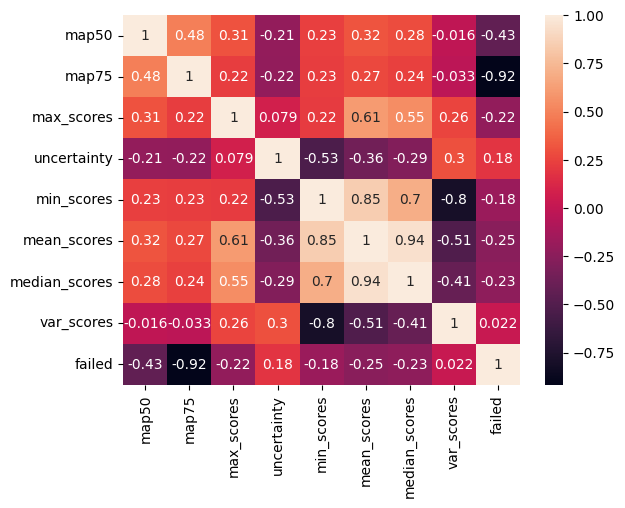

In [11]:
sns.heatmap(df_results_per_img.drop(columns=['all_scores','image_paths']).corr(),annot=True)

In [ ]:
# # load results
# df_results_per_img = pd.read_csv(r"D:\PhD\Data per camp\DetectionDataset\hard_samples\df_results_per_img.csv")

In [ ]:
#uncomment to save
# df_results_per_img.to_csv(r"D:\PhD\Data per camp\DetectionDataset\hard_samples\df_results_per_img.csv",index=False)

In [ ]:
# save hard samples
df_hard_samples = select_hard_samples(df_results_per_img=df_results_per_img,
                                            map_thrs=0.3,
                                            score_thrs=0.,
                                            save_path_samples=r"D:\general_dataset\tiled-data\results\hard_samples_test.txt",
                                            root='D:\\',
                                            # save_data_yaml=r"D:\general_dataset\tiled-data\results\hard_samples.yaml"
                                            )

In [ ]:
df_hard_samples.describe()

In [ ]:
df_hard_samples

# Converting datasets to yolo<>OBB

In [14]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm

from datalabeling.dataset import convert_yolo_to_obb,convert_obb_to_yolo


In [ ]:
#uncomment to run
# convert_yolo_to_obb(yolo_labels_dir=r"D:\general_dataset\train\labels",
#                     skip=True,
#                     output_dir=r"D:\general_dataset\train\labels")

yolo->obb: 928it [00:19, 48.23it/s]


In [ ]:
# # uncomment to run
# convert_obb_to_yolo(obb_labels_dir=r"C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\data\train_wildai\labels",
#                     skpi=True,
#                     output_dir=r"C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\data\train_wildai\labels")